In [ ]:
import sys
sys.path.append('..')
import os
import pandas as pd
import eval_reallabor_utils
import data_utils

MRT = [2, 3]
combined_eval_file = []

for mrt in MRT:

    results_dirs = [
        f'v2_MRT{mrt}_SimpleModels_every_day/00_summary_7stepsahead_on_validation',
        f'v2_MRT{mrt}_Kalman_every_day/00_summary_7stepsahead_ensemble',
        f'v2_MRT{mrt}_every_day/00_summary_7stepsahead_ensemble',
        f'v2_MRT{mrt}_Transformer_every_day/00_summary_7stepsahead_ensemble'
        ]    

    eval_files = []
    for rd in results_dirs:
        eval_files.append(data_utils.join_ordinal_bptt_path('results', rd, 'evaluation.csv'))
        assert os.path.exists(eval_files[-1])
    eval_reallabor_utils.clear_line_and_print(f'Combining evaluation files')
    mrt_combined_eval_file = eval_reallabor_utils.combine_evaluation_files(eval_files, 
                                                                        save_path=None,
                                                                        specifier_name='latent_model')
    mrt_combined_eval_file['MRT'] = mrt

    use_days_from_file = data_utils.train_test_split_path(mrt, 'valid_first_alarms_no_con_smoothed.csv')
    valid_days = pd.read_csv(use_days_from_file, index_col=0)
    valid_days.columns = [int(c) for c in valid_days.columns]

    eval_reallabor_utils.clear_line_and_print(f'Filtering out invalid days')
    eval_only_valid_days = []
    for p, group in mrt_combined_eval_file.groupby('participant'):
        if p in valid_days.columns:
            eval_only_valid_days.append(group.loc[group['test_day'].isin(valid_days[p])])
    mrt_combined_eval_file = pd.concat(eval_only_valid_days, axis=0, ignore_index=True)
    
    mrt_combined_eval_file['prediction'].clip(0, 8, inplace=True)

    combined_eval_file.append(mrt_combined_eval_file)

eval_reallabor_utils.clear_line_and_print(f'Creating grand combined evaluation file')
combined_eval_file = pd.concat(combined_eval_file, axis=0, ignore_index=False)
if not os.path.exists(data_utils.join_ordinal_bptt_path('results/_paper/combined_every_day_ensemble.csv')):
    os.makedirs(data_utils.join_ordinal_bptt_path('results/_paper'), exist_ok=True)
    combined_eval_file.to_csv(data_utils.join_ordinal_bptt_path('results/_paper/combined_every_day_ensemble.csv'))

In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils

MRT = [2, 3]

combined_eval_file = pd.read_csv(data_utils.join_ordinal_bptt_path('results/_paper/combined_every_day_ensemble.csv'), index_col=0)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Create the Differences and Changes Evaluation files

In [2]:
diff_combined_eval_file = eval_reallabor_utils.create_difference_eval_df(combined_eval_file)
change_combined_eval_file = eval_reallabor_utils.create_difference_eval_df(combined_eval_file, only_changes=True)

Calculate all the metrics and their confidence intervals, separately for models and MRT

In [3]:
bootstrap_samples = 10

metrics = {}
errorbars = {}
metrics['mae'] = eval_reallabor_utils.mae(combined_eval_file, ['MRT', 'latent_model', 'participant', 'feature'])
metrics['diff mae'] = eval_reallabor_utils.mae(diff_combined_eval_file, ['MRT', 'latent_model', 'participant', 'feature']).rename('diff_mae')
metrics['change mae'] = eval_reallabor_utils.mae(change_combined_eval_file, ['MRT', 'latent_model', 'participant', 'feature']).rename('change_mae')

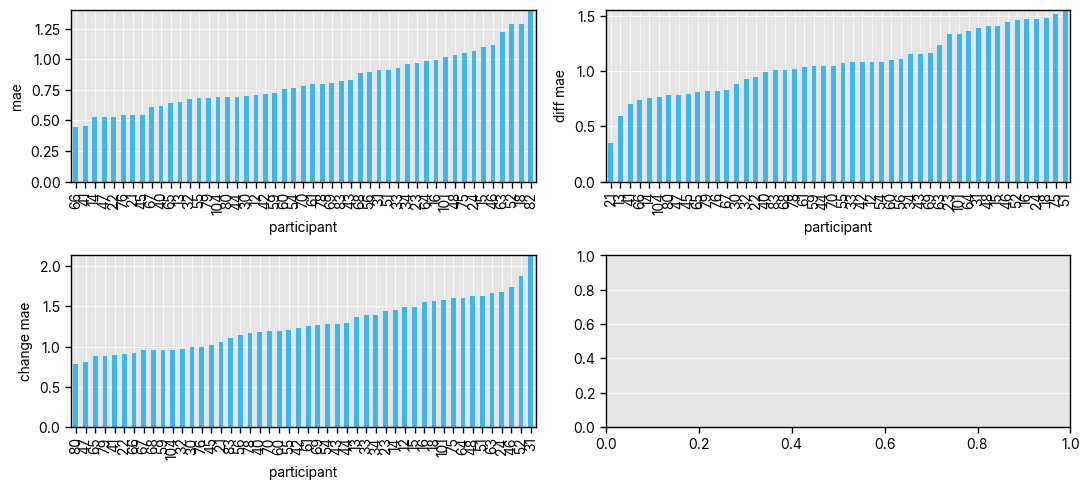

In [5]:
mrt = 2
model = 'clipped-shallow-PLRNN'

from plotting_styles import PaperStyle, colors

with PaperStyle():

    fig, axes = plt.subplots(2, (len(metrics)+1)//2, figsize=[11,5])
    axes = axes.flatten()
    for i, m in enumerate(metrics):
        grouper = metrics[m].loc[(mrt, model)].groupby(['participant'], sort=False)
        mean = grouper.mean().dropna()
        # sem = grouper.sem()
        sorter = mean.argsort()
        mean.iloc[sorter].plot(kind='bar', ax=axes[i])
        axes[i].set(ylabel=m, xticks=range(len(sorter)))
        axes[i].set_xticklabels(mean.index[sorter])
    plt.tight_layout()

    # plt.savefig('../results/_paper/subject_wise.png')
    plt.show()